In [857]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report
from catboost.utils import get_confusion_matrix
import seaborn as sn
import shap

In [858]:
random.seed(24)

# Dog Shelter Adoption Predictor#
<br/>
<a href='https://github.com/Avgustinagr/adoption-prediction'>Github repo</a>  |   
<a href='https://www.notion.so/AI-course-notes-ec1a4d5bba034fe880e751c54300a1e5?pvs=4'>Notion course notes</a>

### Introduction ###

Adopting a dog is no simple decision, there are a lot of factors that should be taken into account. Some future owners look for dogs whose lifestyle needs would align with their own. Some need a working group dog to do a job. Some just look for aesthetics. In this project I am trying to find a set of traits, even within mixed breed shelter dogs, that might predict the length of their shelter stay. Are there traits that make a dog more 'adoptable'?

*If the diagrams don't load, feel free to edit the markdown and uncomment the second diagram line, which uses the local files

#### Datasets: ####
<ol>
    <li><b>Shelter Animal Stays</b> [1] - Intakes and outcomes of animals entering the Austin Animal Center from the beginning of October 2013 to 2018</li>
    <li><b>Dog Breeds</b> [2]- Information about 277 breeds and was extracted from the American Kennel Club website</li>

</ol>

In [859]:
shelter = pd.read_csv('./data/aac_intakes_outcomes.csv')
breeds = pd.read_csv('./data/akc-data-latest.csv')

<hr/>

In [860]:
def get_cols_to_remove(regexes_arr, df):
    cols_to_remove = []
    for regex in regexes_arr:
        cols_to_remove += df.filter(regex = regex).columns.tolist()
    return cols_to_remove

## 1. Shelter clean-up: ##

In the following part I am using the data for shelter animal stay (animal X appears in N rows for each one of its N stays in the shelter) to get a dataset where every row is a unique <b>dog</b> with information about its shelter history.

In [861]:
shelter = shelter.loc[shelter.animal_type == 'Dog'].copy().drop(['animal_type', 'animal_id_outcome'], axis = 1)
shelter = shelter.rename(mapper = {'animal_id_intake': 'animal_id'}, axis = 1)

In [862]:
shelter.shape

(45366, 39)

In [863]:
shelter.head()

,age_upon_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,3,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


In [864]:
shelter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45366 entries, 0 to 79671
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age_upon_outcome            45366 non-null  object 
 1   date_of_birth               45366 non-null  object 
 2   outcome_subtype             13768 non-null  object 
 3   outcome_type                45364 non-null  object 
 4   sex_upon_outcome            45365 non-null  object 
 5   age_upon_outcome_(days)     45366 non-null  int64  
 6   age_upon_outcome_(years)    45366 non-null  float64
 7   age_upon_outcome_age_group  45366 non-null  object 
 8   outcome_datetime            45366 non-null  object 
 9   outcome_month               45366 non-null  int64  
 10  outcome_year                45366 non-null  int64  
 11  outcome_monthyear           45366 non-null  object 
 12  outcome_weekday             45366 non-null  object 
 13  outcome_hour                453

#### Removing duplicate rows and columns: ####

In [865]:
shelter.loc[shelter.duplicated(keep = False)].sort_values('animal_id').shape[0]

24

In [866]:
shelter = shelter.drop_duplicates()

In [867]:
useless_cols_re = [r'.*_\(days\)|_\(years\)$', r'.*_age_group$', r'.*_month|_year|_monthyear|_hour|_days$', r'^age_upon', 'found_location', 'count']
cols_to_remove = get_cols_to_remove(useless_cols_re, shelter)
shelter = shelter.drop(cols_to_remove, axis = 1)

#### Double record of same event: ####
This dog has once been recorded as a case of 'Owner surrender' and once as 'Public Assist'. Since all the datetime values align, it is safe t say it's a duplicated row.

In [868]:
shelter.loc[shelter.duplicated(['animal_id', 'intake_number', 'outcome_number'], keep = False)]

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,outcome_datetime,outcome_weekday,outcome_number,animal_id,breed,color,intake_condition,intake_type,sex_upon_intake,intake_datetime,intake_weekday,intake_number,time_in_shelter
10129,2011-02-17 00:00:00,Aggressive,Euthanasia,Intact Male,2014-04-17 17:09:00,Thursday,1.0,A672744,Rottweiler Mix,Black/Tan,Normal,Public Assist,Intact Male,2014-02-17 17:10:00,Monday,1.0,58 days 23:59:00.000000000
10130,2011-02-17 00:00:00,Aggressive,Euthanasia,Intact Male,2014-04-17 17:09:00,Thursday,1.0,A672744,Rottweiler Mix,Black/Tan,Normal,Owner Surrender,Intact Male,2014-02-17 17:10:00,Monday,1.0,58 days 23:59:00.000000000


In [869]:
shelter = shelter.drop_duplicates(['animal_id', 'intake_number', 'outcome_number'])

#### Color column: ####
A lot of the words in 'color' repeat even if mentioned in different combinations. I wanted to lower the noise so I decided to keep color combinations but fix the pairs by sorting a combination alphabetically. 
<code> {'Black/White': 1, 'White/Black': 1} => {'Black White': 2} </code>

In [ ]:
all_colors = ' '.join(shelter.color.values).replace('/', ' ')
all_colors_word_count = Counter(all_colors.split(' '))
all_colors_word_count

In [871]:
shelter['color'] = shelter.color.str.split('/').apply(lambda vals: ' '.join(sorted(vals)))

In [873]:
shelter.color.value_counts()

Black White            6765
Brown White            3989
Tan White              3616
Black                  2507
Black Brown            2480
                       ... 
Brown Chocolate          15
Blue Tricolor            15
Black Black Brindle      15
Brown Sable              15
Apricot White            15
Name: color, Length: 91, dtype: int64

### Datatypes: ###
#### Datetime columns: ####

In [874]:
dt_col_regex = r'^date_|_datetime$'

cols_to_dt = shelter.filter(regex = dt_col_regex).columns
for col in cols_to_dt:
    shelter[col] = pd.to_datetime(shelter[col])

#### Timedelta column: ####
Redundant data but will be useful for calculations

In [875]:
shelter['time_in_shelter'] = shelter['outcome_datetime'] - shelter['intake_datetime']

#### Categorical columns: ####

In [876]:
categorical_regex = r'_type$|_subtype$|_weekday$|breed$'
categorical_cols = shelter.filter(regex = categorical_regex)

for col in categorical_cols:
    shelter[col] = shelter[col].astype('category')

### Checking for broken rows: ###
Checking for logical inconsistencies with the dates

In [877]:
print (shelter.loc[shelter.intake_datetime > shelter.outcome_datetime].shape[0])
print (shelter.loc[shelter.date_of_birth > shelter.intake_datetime].shape[0])
print (shelter.loc[shelter.date_of_birth > shelter.outcome_datetime].shape[0])

0
39
2


<b> Why I decided to keep the intake date as date of birth: </b><br>
At fist I assumed these were the puppies born in the shelter but after further investigation not all of them were in 'Nursing state' and also there were some, whose date of birth was even later than their outcome date. <u>Date of birth is expected to be a value that is estimated by the shelter staff.</u> so for those cases, I will use intake date as date of birth. The mean of discrepancies is low so I don't expect this to have a big impact on the results.

In [878]:
shelter_time_discrepanies = shelter.loc[(shelter.date_of_birth > shelter.intake_datetime)]
time_discrepanies = shelter_time_discrepanies.apply(lambda x: x.date_of_birth - x.intake_datetime, axis = 1)
time_discrepanies.mean()

Timedelta('9 days 14:22:13.846153846')

In [879]:
def fix_date_of_birth(row):
    """ 
        Fix rows claiming that the animal was born after
        it was taken in
    """
    if row.date_of_birth > row.intake_datetime: 
        return row.intake_datetime
    return row.date_of_birth

In [880]:
shelter['fixed_date_of_birth'] = shelter.apply(fix_date_of_birth, axis = 1)

In [881]:
print (shelter.loc[shelter.fixed_date_of_birth > shelter.intake_datetime].shape[0])
print (shelter.loc[shelter.fixed_date_of_birth > shelter.outcome_datetime].shape[0])

0
0


In [882]:
shelter['date_of_birth'] = shelter['fixed_date_of_birth']
shelter = shelter.drop('fixed_date_of_birth', axis = 1)

### Adding age_intake column: ###

In [883]:
def get_age(dob, to_time):
    return round((to_time - dob).dt.days / 365.25)

In [884]:
shelter['age_intake'] = get_age(shelter.date_of_birth, shelter.intake_datetime)

## Calculating total shelter stay: ##
In this dataset, one row represents one shelter stay (PK is compound: animal_id and intake_datetime). A dog can get adopted, then left at the shleter again and so on and each of those stays is recorded as a row. My goal requires a dataset where every row is a unique dog (PK is animal_id). To achieve that I must, for every dog:
<ol>
    <li>Take the <b>first intake</b> data - I am interested in when was the first time the dog got in the shelter</li>
    <li>Take the <b>last outcome</b> data - I am interested in the last outcome - what's the dog's status now.</li>
    <li><b>Sum the time in shelter for each stay</b> - This will give me the total shelter time between the first intake and the last outcome <b>without the gaps</b> in between stays</li>
</ol>

![From shelter stays to dogs](https://i.ibb.co/7Ny0pDW/Diagram1-m.png)
<!-- ![From shelter stays to dogs](./Diagram1_m.png) -->

#### Step 1: Separate intakes from outcomes ####
I separate the dataset into two with only their relevant columns. The 'common' columns like 'date_of_birth' will go to the intakes.

In [885]:
shelter.loc[shelter.intake_number != shelter.outcome_number]

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,outcome_datetime,outcome_weekday,outcome_number,animal_id,breed,color,intake_condition,intake_type,sex_upon_intake,intake_datetime,intake_weekday,intake_number,time_in_shelter,age_intake


In [886]:
intakes = shelter[[
    'animal_id', 
    'date_of_birth', 
    'breed',
    'intake_type', 
    'intake_condition', 
    'age_intake',
    'intake_datetime', 
    'intake_weekday',
    'intake_number',
    'sex_upon_intake',
    'color'
    # this column won't make sense anymore
    # 'time_in_shelter'
]].copy()

In [887]:
outcomes = shelter[[
    'animal_id',
    'outcome_subtype',
    'outcome_type',
    'outcome_datetime',
    'outcome_weekday', 
    'outcome_number']].copy()

In [888]:
print (intakes.duplicated().sum())
print (outcomes.duplicated().sum())

0
0


####  Step 2: Taking first instake and last outcome: ####

In [889]:
intakes = intakes.sort_values('intake_number')
first_intakes = intakes.drop_duplicates('animal_id')

In [890]:
outcomes = outcomes.sort_values('outcome_number')
last_outcomes = outcomes.drop_duplicates('animal_id', keep = 'last')

#### Step 3: Merging first intakes and last outcomes: ####
This gives me a dataset where each row is a unique dog along with its simplified shelter history.

In [891]:
dogs = pd.merge(first_intakes, last_outcomes, how = 'inner', on = 'animal_id')

#### Step 4: Calculating total shelter time: ####
<b>Back in the shelters dataset</b>, I sum up the shelter time for every dog. That gives me a series with the animal_ids as index and their total shelter time as values. Then I join it with dogs dataset by animal id to get their total shelter stay (without the gaps)

In [892]:
animals_total_time = shelter.groupby('animal_id')['time_in_shelter'].sum()
animals_total_time.name = 'total_time_in_shelter'

In [893]:
dogs = pd.merge(dogs, animals_total_time, on = 'animal_id')

#### Dropping unnecessary cols: ####
Just leaving the number of stays for now, not sure if i'll need it

In [894]:
dogs = dogs.rename(mapper = {'outcome_number': 'stays_count'}, axis = 1)
dogs = dogs.drop('intake_number', axis = 1)

<hr>

## 2. Breeds clean-up ##

This is the registered dog breed dataset from the American Kennel Club.

In [895]:
breeds.head(3)

,Unnamed: 0,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,...,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,...,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,...,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly


In [896]:
breeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   277 non-null    object 
 1   description                  277 non-null    object 
 2   temperament                  276 non-null    object 
 3   popularity                   198 non-null    object 
 4   min_height                   277 non-null    float64
 5   max_height                   277 non-null    float64
 6   min_weight                   275 non-null    float64
 7   max_weight                   275 non-null    float64
 8   min_expectancy               274 non-null    float64
 9   max_expectancy               274 non-null    float64
 10  group                        277 non-null    object 
 11  grooming_frequency_value     270 non-null    float64
 12  grooming_frequency_category  270 non-null    object 
 13  shedding_value      

#### Column clean-up: ####

In [897]:
breeds = breeds.rename(mapper = {'Unnamed: 0': 'breed'}, axis = 1)

In [898]:
breeds['group'] = breeds['group'].astype('category')

In [899]:
useless_cols_re = [r'popularity', r'_category$']
cols_to_remove = get_cols_to_remove(useless_cols_re, breeds)
breeds = breeds.drop(columns = cols_to_remove, axis = 1)

#### Checking for duplicates: ####

In [900]:
print (breeds.duplicated().sum())
print (breeds.duplicated('breed').sum())

0
0


In [901]:
breeds.loc[(breeds.min_weight < 1) | (breeds.max_weight < 1)]

,breed,description,temperament,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
65,Cane Corso,At nearly 28 inches at the shoulder and often ...,"Affectionate, Intelligent, Majestic",59.69,69.85,0.0,0.0,9.0,12.0,Working Group,0.2,0.4,0.8,0.6,0.6


In [902]:
breeds.loc[65, 'min_weight'] = 90
breeds.loc[65, 'max_weight'] = 110

## 3. Shelter: One row per breed mix part: ##
Stray dogs are not expected to be of a pure breed. The values in the breed column often contain the word 'Mix' or have 1 or 2 breeds mentioned. I assume the breeds are given by the staff based off of an estimation of appearance, weight, demeanor etc. So while breed itself might not be very accurate, I assume that the size and demeanor related to it will be.<br/>

Before I merge shelter and breeds, I must:
<ol>
    <li><b>Explode the breed column</b>. This will give me one row for every breed that a dog has traits of. (PK is animal_id and breed)</li>
    <li>Find all <b>unmatched breeds</b></li>
    <li>Take care of them</li>
</ol>

![Mixed breeds](https://i.ibb.co/3hQ9Qjr/Diagram2-m.png)
<!-- ![Mixed breeds](./Diagram2_m.png) -->



The word 'Mix' carries information, however, not information that I can do anything with at the moment. I assume the value will be more useful without it because it can be matched to a breed.

In [903]:
dogs['breed'] = dogs['breed'].apply(lambda breed: re.sub('Mix', '', breed))

Black/Tan Hound becomes Black and Tan Coohhound to remove instances of '/' not separating two breed mixes:


In [904]:
dogs['breed'] = dogs['breed'].apply(lambda breed: re.sub('Black/Tan Hound', 'Black and Tan Coonhound', breed))

#### Step 1: Explode breed column: ####
For the sake of a smooth merge, I will need a row for every breed that a dog has 'mixed in'. That means that one animal_id will appear twice if it is a mix between two breeds.

In [905]:
dogs_mixes = dogs.copy()
dogs_mixes['breed'] = dogs_mixes['breed'].str.split('/')
dogs_mixes.shape

(38909, 16)

In [906]:
dogs_mixes = dogs_mixes.explode(column = 'breed')

In [907]:
dogs_mixes.sort_values('animal_id').head()

,animal_id,date_of_birth,breed,intake_type,intake_condition,age_intake,intake_datetime,intake_weekday,sex_upon_intake,color,outcome_subtype,outcome_type,outcome_datetime,outcome_weekday,stays_count,total_time_in_shelter
0,A006100,2007-07-09,Spinone Italiano,Stray,Normal,10.0,2017-12-07 00:00:00,Thursday,Neutered Male,White Yellow,NaN,Return to Owner,2014-03-08 17:10:00,Saturday,3.0,2 days 23:05:00
28010,A047759,2004-04-02,Dachshund,Owner Surrender,Normal,10.0,2014-04-02 15:55:00,Wednesday,Neutered Male,Tricolor,Partner,Transfer,2014-04-07 15:12:00,Monday,1.0,4 days 23:17:00
28011,A134067,1997-10-16,Shetland Sheepdog,Public Assist,Injured,16.0,2013-11-16 09:02:00,Saturday,Neutered Male,Brown White,NaN,Return to Owner,2013-11-16 11:54:00,Saturday,1.0,0 days 02:52:00
28012,A141142,1998-06-01,Labrador Retriever,Stray,Aged,15.0,2013-11-16 14:46:00,Saturday,Spayed Female,Black White,NaN,Return to Owner,2013-11-17 11:40:00,Sunday,1.0,0 days 20:54:00
28012,A141142,1998-06-01,Pit Bull,Stray,Aged,15.0,2013-11-16 14:46:00,Saturday,Spayed Female,Black White,NaN,Return to Owner,2013-11-17 11:40:00,Sunday,1.0,0 days 20:54:00


In [908]:
dogs_mixes['breed'] = dogs_mixes['breed'].apply(lambda br: br.strip().replace('St.', 'Saint'))

#### Step 2: Merge and add 'has_match' column: ####
I want to know which rows need their breed 'fixed' in order to smoothly merge with 'breeds' dataframe. <br>
So I merge with only the breed column and use description column as flag - if empty -> breed is not matched. (After checking that all breeds have description)

In [909]:
dogs_mixes = pd.merge(dogs_mixes, breeds[['breed', 'description']], how = 'left', on = 'breed')

step 2: Rename column and convert values to boolean

In [910]:
dogs_mixes['description'] = dogs_mixes['description'].apply(lambda x: not pd.isnull(x))

In [911]:
dogs_mixes = dogs_mixes.rename({'description': 'has_match'}, axis = 1)

In [912]:
dogs_mixes.has_match.dtype

dtype('bool')

#### Step 3: Take care of unmatched breeds ####

At first I tried to map the unmatched ones to the AKC breeds by hand and I noticed a pattern - if the breed existed in the AKC dataset, usually <b>at least one word on the unmatched breed would be contained in some word in the official version.</b>. (e.g.  'Mini Poodle' => 'Poodle (Miniature)' or 'Cavalier Span' -> 'Cavalier King Charles Spaniel') So with some *restrictions, I managed to automate the process with very good results. <br><br>
For an unmatched breed, I separate it into words (after lowering, strip, removing punctuation etc) and try to match it to each word in the official breeds. At the end, I have a dataset ('breed' , 'score'), which keeps score of how many words have been matched.<br>
Out of that dataset, the breeds with max score are put in a list and mapped to the unmatched name: <br><br>
<code> shelter_to_akc_breeds = { 'Collie Smooth': ['Bearded Collie', 'Border Collie', 'Collie', 'Smooth Fox Terrier'], ...} </code><br><br>
This dictionary is later used to fill in the missing breeds, using random where there are more than one.<br/><br>
*restrictions mentioned - I only match from the start (see is_word_in_breed()) to avoid "meaningless" matches like '<b>Pit</b> Bull</b>' and 'Chinese S<b>pit</b>s'. I also have an array of THROW OFFS for the same reason - avoiding words that won't help the matching process. For comparison:
<uol>
<li>'shorthair' - is not so descriptive of the breed as it is of the fur. Causs matches with breeds with all kinds of characteristics.</li>
<li>'hound' - may lead to a match that's not exactly the same type of hound but it still narrows down to a subset with similar characteristics</li>
</uol>

In [913]:
reg_breeds = breeds.breed
THROW_OFFS = ['longhair', 'shorthair', 'english']

In [914]:
def normalize_str(str):
    return re.sub(r'[-()]', '', str.lower()).strip()

In [915]:
def is_word_in_breed(breed, word):
    """ 
        Matches "word" to the beginning of
        every word in "row.breed"
        pit -x-> spits
        span --> spaniel
    """
    breed = normalize_str(breed)
    match_from_start = r'^' + word + '| ' + word
    to_add = 1 if re.search(match_from_start, breed) else 0
    return to_add

In [916]:
def get_match_score_of_row(row, word):
    return row['score'] + is_word_in_breed(row.breed, word)

In [917]:
def best_breed_matches(breed):
    """
        Returns a list of AKC registered breeds that best match 'breed'
    """
    breed_words = [normalize_str(word) for word in breed.split()]
    
    breed_match = breeds[['breed']].copy()
    breed_match['score'] = 0;
    
    for word in breed_words:
        if word in THROW_OFFS:
            continue
        breed_match['score'] = breed_match.apply(lambda row: get_match_score_of_row(row, word), axis = 1)
        
    top_matches =  breed_match.loc[breed_match['score'] == breed_match['score'].max()].reset_index()
    return top_matches['breed'].tolist() if (top_matches['score'].max() > 0) else []

Creating a dictionary for breed mapping from the unofficial unmatched breeds to the AKC registered breeds.

In [918]:
unmatched_breeds = dogs_mixes.loc[~dogs_mixes['has_match'], 'breed'].unique()

In [919]:
shelter_to_akc_breeds = {}

for unmatched_breed in unmatched_breeds:
    shelter_to_akc_breeds[unmatched_breed] = best_breed_matches(unmatched_breed)

shelter_to_akc_breeds

{'Chihuahua Shorthair': ['Chihuahua'],
 'Queensland Heeler': ['Lancashire Heeler'],
 'Pit Bull': ['American Bulldog',
  'Bull Terrier',
  'Bulldog',
  'Bullmastiff',
  'French Bulldog',
  'Miniature Bull Terrier',
  'Staffordshire Bull Terrier'],
 'Catahoula': ['Catahoula Leopard Dog'],
 'Mexican Hairless': ['American Hairless Terrier'],
 'German Shorthair Pointer': ['German Longhaired Pointer',
  'German Shorthaired Pointer',
  'German Wirehaired Pointer'],
 'Anatol Shepherd': ['Anatolian Shepherd Dog'],
 'Wire Hair Fox Terrier': ['Wire Fox Terrier'],
 'German Shepherd': ['German Shepherd Dog'],
 'Chihuahua Longhair': ['Chihuahua'],
 'Staffordshire': ['American Staffordshire Terrier',
  'Staffordshire Bull Terrier'],
 'Black Mouth Cur': ['Black and Tan Coonhound',
  'Black Russian Terrier',
  'Curly-Coated Retriever',
  'Mountain Cur'],
 'Jack Russell Terrier': ['Parson Russell Terrier', 'Russell Terrier'],
 'Blue Lacy': ['Bluetick Coonhound', 'Kerry Blue Terrier'],
 'Miniature Poodle

#### Filling in the missing values: ####

In [920]:
def match_dog_breed(row, breed_dict = shelter_to_akc_breeds):
    """ 
        Takes a row and a dictionary mapping shelter breeds to AKC breeds
        If row.has_match is false, 
        it assigns it one of the values of breed_dict[row.breed]
    """
    dog_misses_breed = not row.has_match
    if dog_misses_breed:
        possible_breeds = breed_dict[row.breed]
        if not len(possible_breeds): return None
        return possible_breeds[random.randint(0, len(possible_breeds) - 1)]
    return row.breed_match if hasattr(row, 'breed_match') else row.breed

In [921]:
dogs_mixes['breed_match'] = dogs_mixes.apply(match_dog_breed, axis = 1)

In [922]:
# Updating has_match
dogs_mixes['has_match'] = dogs_mixes.apply(lambda row: not pd.isnull(row.breed_match), axis = 1)
dogs_mixes.head(5)

,animal_id,date_of_birth,breed,intake_type,intake_condition,age_intake,intake_datetime,intake_weekday,sex_upon_intake,color,outcome_subtype,outcome_type,outcome_datetime,outcome_weekday,stays_count,total_time_in_shelter,has_match,breed_match
0,A006100,2007-07-09,Spinone Italiano,Stray,Normal,10.0,2017-12-07 00:00:00,Thursday,Neutered Male,White Yellow,NaN,Return to Owner,2014-03-08 17:10:00,Saturday,3.0,2 days 23:05:00,True,Spinone Italiano
1,A726434,2009-05-10,Chihuahua Shorthair,Stray,Normal,7.0,2016-05-10 18:08:00,Tuesday,Intact Male,Black White,NaN,Adoption,2016-05-22 13:21:00,Sunday,1.0,11 days 19:13:00,True,Chihuahua
2,A726435,2013-05-10,Dachshund,Owner Surrender,Normal,3.0,2016-05-21 18:08:00,Saturday,Spayed Female,Black White,NaN,Adoption,2016-05-17 17:56:00,Tuesday,2.0,135 days 14:39:00,True,Dachshund
3,A726442,2015-12-11,Queensland Heeler,Stray,Normal,0.0,2016-05-10 18:55:00,Tuesday,Intact Male,Tan White,NaN,Adoption,2016-05-14 18:00:00,Saturday,1.0,3 days 23:05:00,True,Lancashire Heeler
4,A726442,2015-12-11,Dachshund,Stray,Normal,0.0,2016-05-10 18:55:00,Tuesday,Intact Male,Tan White,NaN,Adoption,2016-05-14 18:00:00,Saturday,1.0,3 days 23:05:00,True,Dachshund


#### A few more missing values ####

Breeds the mapper failed to recognize because they are aliases. And a few unknowns. I manually created a dictionary for them.

In [923]:
dogs_mixes.loc[dogs_mixes['breed_match'].isnull()]['breed'].value_counts()

Pbgv        28
Feist       16
Landseer    10
Lowchen      3
Akbash       2
Unknown      2
Kangal       1
Name: breed, dtype: int64

In [924]:
# Dropping 'Unknown' breeds
dogs_mixes = dogs_mixes.loc[dogs_mixes['breed'] != 'Unknown'].copy()

In [925]:
manual_breed_match = {
    'Pbgv': ['Petit Basset Griffon Vendéen'],
    'Feist': ['Rat Terrier'],
    'Landseer': ['Newfoundland'],
    'Lowchen': ['Löwchen'],
    'Akbash': ['Anatolian Shepherd Dog'],
    'Kangal': ['Anatolian Shepherd Dog']
}

In [926]:
# Matching dog breeds with manual map this time
dogs_mixes['breed_match'] = dogs_mixes.apply(lambda row: match_dog_breed(row, manual_breed_match), axis = 1)

In [927]:
# Updating has_match
dogs_mixes['has_match'] = dogs_mixes.apply(lambda row: not pd.isnull(row.breed_match), axis = 1)

In [928]:
dogs_mixes[dogs_mixes.has_match == False].shape[0]

0

## 4. Dealing with breed mixes by mixing breeds ##

Every row now corresponds to exactly one breed from the 'breeds' dataset. My next goal is for one row to represent one unique dog with breed information and shelter history. 

<b>The question is, how will a dog of mixed breed be mapped to a dataset of pure breeds?</b><br>
In order to account for the 'mixes' I will try to 'mix' the breeds in the dataset as well - try to 'derive' the mixed breed out of the main ones by averaging values. That's my best guess at the moment.


<ol>
    <li>Merge with breeds while there's still one breed per row</li>
    <li>
        Pivot breed columns
    </li>
    <li>
        "Mix" breeds:<br>
            - Numerical features - take the mean of the two breeds<br/>
            - Categorical features - if they differ, put in 'Miscellaneous Class'<br/>
            - * Descri
        ption - keeping both columns for now<br/>
            - * Temperament - taking the set of all characteristics mentioned for both breeds<br/>
    </li>
    <li>Discard useless columns</li>
</ol>

![Representing a breed mix](https://i.ibb.co/gt01sjP/Diagram3-m.png)
<!-- ![Representing a breed mix](./Diagram3_m.png) -->

#### Step 1: Merge with breeds: ####

In [929]:
dogs_mixes['breed_num'] = dogs_mixes.groupby('animal_id').cumcount()

In [930]:
dogs_breeds = pd.merge(dogs_mixes, breeds, how = 'left', left_on = 'breed_match', right_on = 'breed')

#### Mid-step: dropping and renaming columns

In [931]:
dogs_breeds = dogs_breeds.rename({'breed_x': 'breed'}, axis = 1)

In [932]:
def average_row_vals():
    dogs_breeds['avg_height'] = dogs_breeds[['min_height', 'min_height']].mean(axis=1)
    dogs_breeds['avg_weight'] = dogs_breeds[['min_weight', 'max_weight']].mean(axis=1)
    dogs_breeds['avg_expectancy'] = dogs_breeds[['min_expectancy', 'max_expectancy']].mean(axis=1)

In [933]:
average_row_vals()

In [934]:
more_useless_cols_re = [r'_y$', r'^min_|max_']
cols_to_remove = get_cols_to_remove(more_useless_cols_re, dogs_breeds)

dogs_breeds = dogs_breeds.drop(cols_to_remove, axis = 1)

#### Step 2: Pivot breed columns ####

In [935]:
pivoted = dogs_breeds.pivot(
    index='animal_id', 
    columns='breed_num', 
    values=[
    'breed_match', 
    'breed', 
    'description',
    'group', 
    'temperament',
    'avg_height',
    'avg_weight',
    'avg_expectancy',
    'grooming_frequency_value',
    'shedding_value',
    'energy_level_value',
    'trainability_value',
    'demeanor_value'
    ]).reset_index()

#### Step 3: "Mix" breeds ####
Taking the mean of all numerical columns:

In [936]:
numerical_cols= [
    'avg_height',
    'avg_weight',
    'avg_expectancy',
    'grooming_frequency_value',
    'shedding_value',
    'energy_level_value',
    'trainability_value',
    'demeanor_value']

In [937]:
for col in numerical_cols:
    pivoted[col + '_mixed'] =  pivoted[col].mean(axis = 1)

In [938]:
cols = [col + (('_' + str(num))if str(num) else '') for col, num in pivoted.columns]

In [939]:
pivoted.columns = cols

In [940]:
more_useless_cols_re = [r'_value_[0-9]$', '^avg_.*_[0-9]$']
cols_to_remove = get_cols_to_remove(more_useless_cols_re, pivoted)

pivoted = pivoted.drop(cols_to_remove, axis = 1)

### Fixing categorical and string cols: ####

#### Fix temperament: ####
Temperament is usually a string of three traits separated by a column. For the "mix" I take the set of those traits.

In [941]:
def join_vals(temperaments):
    str1 = temperaments['temperament_0']
    str2 = temperaments['temperament_1']
    str1 = str1 if not pd.isnull(str1) else ''
    str2 = str2 if not pd.isnull(str2) else ''
    return str1 + (', ' + str2 if str2 else '')

In [942]:
pivoted['temperament'] = pivoted[['temperament_0', 'temperament_1']].agg(join_vals, axis = 1).str.lower()

In [943]:
pivoted = pivoted.drop(['temperament_0', 'temperament_1'], axis = 1)

In [944]:
pivoted.head(3)

,animal_id,breed_match_0,breed_match_1,breed_0,breed_1,description_0,description_1,group_0,group_1,avg_height_mixed,avg_weight_mixed,avg_expectancy_mixed,grooming_frequency_value_mixed,shedding_value_mixed,energy_level_value_mixed,trainability_value_mixed,demeanor_value_mixed,temperament
0,A006100,Spinone Italiano,NaN,Spinone Italiano,NaN,The Spinone Italiano (plural: Spinoni Italiani...,NaN,Sporting Group,NaN,55.88,NaN,11.0,0.4,NaN,0.8,0.6,0.6,"sociable, patient, docile"
1,A047759,Dachshund,NaN,Dachshund,NaN,"The word “icon” is terribly overworked, but th...",NaN,Hound Group,NaN,12.70,9.752236,14.0,0.4,0.4,0.6,0.6,0.6,"friendly, curious, spunky"
2,A134067,Shetland Sheepdog,NaN,Shetland Sheepdog,NaN,"The Shetland Sheepdog is a small, active, and ...",NaN,Herding Group,NaN,33.02,9.071847,13.0,0.6,0.6,0.6,1.0,0.4,"playful, energetic, bright"


#### Fix Group: ####
Group is a categorical feature. If the two groups are not the same, I assign 'Miscellaneous Class'

In [945]:
pivoted.group_1.value_counts(dropna = False)

NaN                         32741
Sporting Group               1055
Toy Group                     989
Herding Group                 963
Hound Group                   834
Terrier Group                 717
Non-Sporting Group            700
Working Group                 649
Foundation Stock Service      236
Miscellaneous Class            24
Name: group_1, dtype: int64

In [946]:
mismatched_idxs = np.array((pivoted['group_0'] != pivoted['group_1']) & ~pd.isnull(pivoted['group_1']))

In [947]:
pivoted.loc[mismatched_idxs, 'group_0'] = pivoted.loc[mismatched_idxs].apply(
        lambda row: row['group_0'] + '/' + row['group_1'], axis = 1)

In [948]:
pivoted = pivoted.drop(columns = ['group_1'])
pivoted = pivoted.rename({'group_0': 'group'}, axis = 1)

In [949]:
pivoted.dtypes

animal_id                          object
breed_match_0                      object
breed_match_1                      object
breed_0                            object
breed_1                            object
description_0                      object
description_1                      object
group                              object
avg_height_mixed                  float64
avg_weight_mixed                  float64
avg_expectancy_mixed              float64
grooming_frequency_value_mixed    float64
shedding_value_mixed              float64
energy_level_value_mixed          float64
trainability_value_mixed          float64
demeanor_value_mixed              float64
temperament                        object
dtype: object

## 5. Getting one dog per row ##
Merging pivoted with dog_breeds on animal_id so I can get each dog's shelter history and breed information.<br>

At this point from 'dogs_breeds' I only need the shelter history data, which repeats on rows withthe same animal_id. That will allow me to join it on the right of 'pivoted'.

In [972]:
right = dogs_breeds[[
        'animal_id', 
        'date_of_birth', 
        'intake_type', 
        'intake_condition', 
        'age_intake', 
        'intake_datetime', 
        'intake_weekday',
        'color', 
        'outcome_subtype',
        'outcome_type',
        'outcome_datetime', 
        'outcome_weekday', 
        'stays_count',
        'total_time_in_shelter',
        'sex_upon_intake'
]]

In [951]:
mixed_dogs = pd.merge(pivoted, right, how = 'left', on = 'animal_id')

In [952]:
mixed_dogs = mixed_dogs.drop(['breed_0', 'breed_1'], axis = 1)
mixed_dogs = mixed_dogs.rename({'breed_match_0': 'breed_0', 'breed_match_1': 'breed_1'}, axis = 1)

## Exploration ##

In [1313]:
def plot_barchart(df, feature, xlabel, ylabel, title, show = True):
    feature_counts = df[feature].value_counts()
    plt.bar(feature_counts.keys(), feature_counts.values)
    plt.xticks(rotation = 80)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if show:
        plt.show()

def plot_hist(values, xlabel, ylabel, title, bins = 10, show = True, alpha = 1, label = ''):
    plt.hist(values, bins = bins, alpha = alpha, label = label)
    plt.xticks(rotation = 80)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if show:
        plt.show()

## A big assumption: ##

Sadly, 'Adoption' isn't the only outcome for a dog which has found itself in a shelter. Since I want to predict if a dog will get adopted in a week or more, my question is not considering other possible outcomes. A big assumption is made that the dogfor which the prediction is made <b>will get adopted at some point</b>

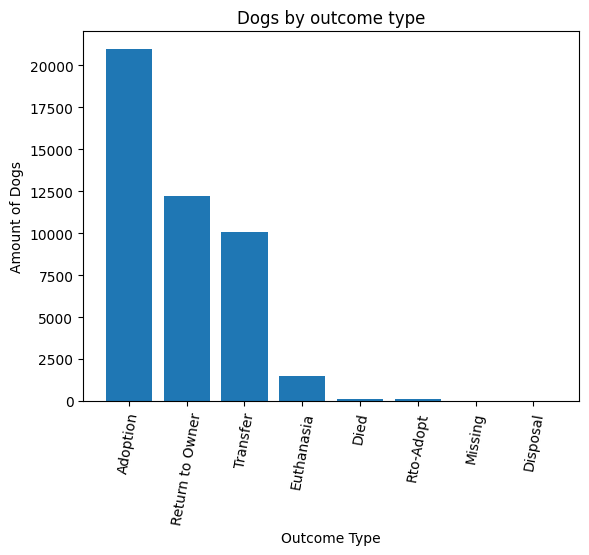

In [1314]:
plot_barchart(mixed_dogs, 'outcome_type', 'Outcome Type', 'Amount of Dogs', 'Dogs by outcome type')

In [1369]:
adopted = mixed_dogs.loc[mixed_dogs.outcome_type.isin(['Adoption'])].copy()

In [1370]:
adopted['days_in_shelter'] = adopted.total_time_in_shelter.dt.days
adopted['month_intake'] = adopted.intake_datetime.dt.month
adopted['weekday_intake'] = adopted.intake_datetime.dt.weekday
adopted['year_intake'] = adopted.intake_datetime.dt.year

In [1317]:
for color, color_gr in adopted.groupby('color'):
    if color_gr.shape[0] < 20:
        adopted.loc[adopted['color'] == color, 'color'] = 'Other'

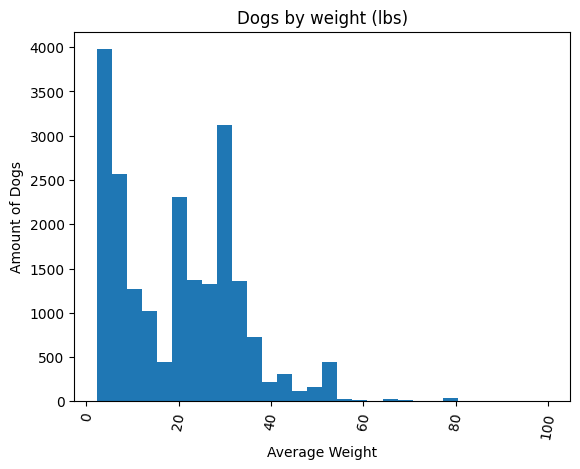

In [1318]:
plot_hist(adopted.avg_weight_mixed, 'Average Weight', 'Amount of Dogs', 'Dogs by weight (lbs)', 30)

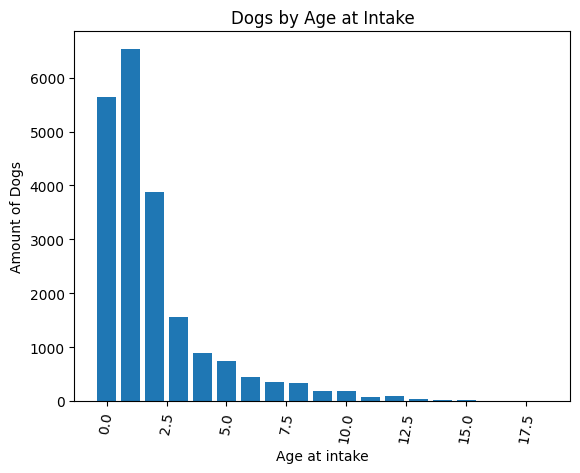

In [1319]:
plot_barchart(adopted, 'age_intake', 'Age at intake', 'Amount of Dogs', 'Dogs by Age at Intake')

More dogs are taken in during winter and not so many uring the warmer months.

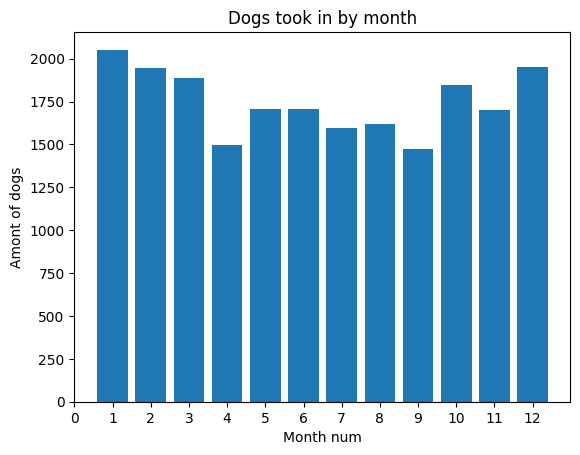

In [1358]:
feature_counts = adopted['month_intake'].value_counts()
plt.bar(feature_counts.keys(), feature_counts.values)
plt.xlabel('Month num')
plt.ylabel('Amont of dogs')
plt.xticks([i for i in range(13)])
plt.title('Dogs took in by month')
plt.show()

### Extracting the target: ###

The distribution has a very long right tail - a lot of the dogs are adopted within the first few days. As the days get bigger, the amount of dogs that have stayed that much gets exponentially smaller. That's nice because it means most of the dogs get rehomed quite fast. Also, there are instances of dogs that have waited for years and have still found a home.<br>
Overlayed on top of the total amount of dogs, we can see that there are a lot of dogs within the first few days that have a different outcome than 'Adoption'. After further investigation, 'Return to Owner' seems to be the biggest reason for that as, apparently, a lot of dogs get returned to their owner within 7 days, most likely after getting lost.

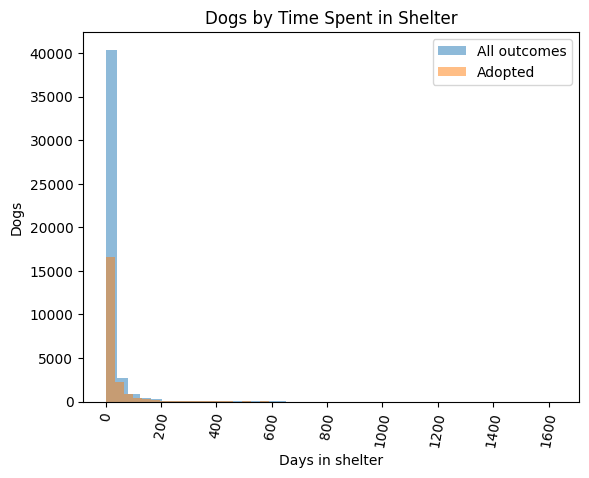

In [1403]:
plot_hist(dogs_mixes.total_time_in_shelter.dt.days, 'Days in shelter', 'Dogs', 'Dogs by Time Spent in Shelter', 40, show = False, alpha = 0.5, label = 'All outcomes')
plot_hist(adopted.total_time_in_shelter.dt.days, 'Days in shelter', 'Dogs', 'Dogs by Time Spent in Shelter', 40, show = False, alpha = 0.5, label = 'Adopted')
xs = np.linspace(0, 1200, 1000)
plt.legend()
plt.show()

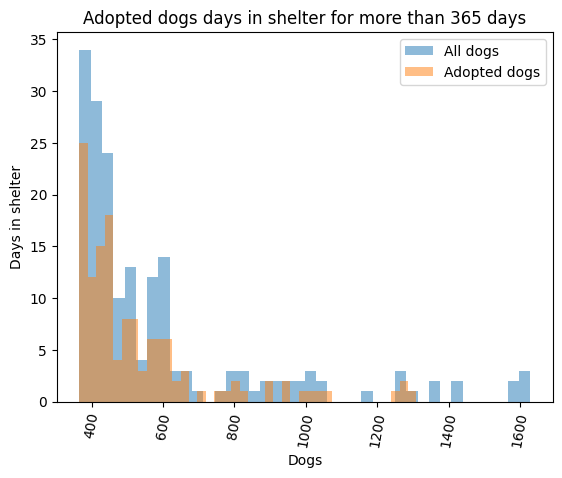

In [1405]:
long_stay_dogs = mixed_dogs.loc[mixed_dogs.total_time_in_shelter.dt.days > 365, 'total_time_in_shelter'].dt.days
long_stay_adopted_dogs = adopted.loc[adopted.total_time_in_shelter.dt.days > 365, 'total_time_in_shelter'].dt.days

plot_hist(long_stay_dogs, 'Dogs', 'Days in shelter', 'Dogs days in shelter for more than 365 days', show = False, bins = 40, alpha = 0.5, label = 'All dogs')
plot_hist(long_stay_adopted_dogs, 'Dogs', 'Days in shelter', 'Adopted dogs days in shelter for more than 365 days', show = False, bins = 40, alpha = 0.5, label = 'Adopted dogs')
plt.legend()
plt.show()

In [1406]:
long_stay_adopted_dogs.shape[0] / long_stay_dogs.shape[0]

0.7362637362637363

In [1407]:
adopted.shape[0] / mixed_dogs.shape[0]

0.4654908485856905

In [1408]:
mixed_dogs.loc[mixed_dogs.outcome_type == 'Return to Owner', 'total_time_in_shelter'].dt.days.describe()

count    12248.000000
mean         8.749755
std         54.615594
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max       1629.000000
Name: total_time_in_shelter, dtype: float64

In [1413]:
print (adopted.loc[adopted.total_time_in_shelter.dt.days < 10, 'total_time_in_shelter'].shape[0], 'dogs that have been adopted in LESS than 10 days')

11775 dogs that have been adopted in LESS than 10 days


In [1412]:
print (adopted.loc[adopted.total_time_in_shelter.dt.days > 10, 'total_time_in_shelter'].shape[0], 'dogs that have been adopted in MORE than 10 days')

8681 dogs that have been adopted in MORE than 10 days


### Threshold that will define the two classes of target: ###

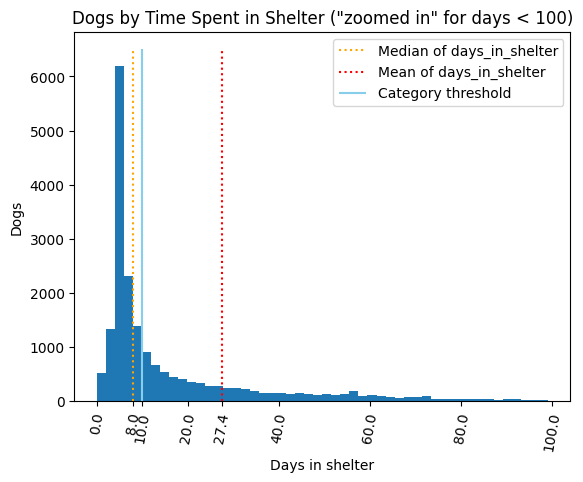

In [1365]:
adopted_less_than = adopted.loc[adopted.total_time_in_shelter.dt.days < 100, 'total_time_in_shelter'].dt.days
plot_hist(adopted_less_than, 'Days in shelter', 'Dogs', 'Dogs by Time Spent in Shelter ("zoomed in" for days < 100)', bins = 50, show = False)

less_than_mean = mixed_dogs.total_time_in_shelter.dt.days.mean()
adopted_median = adopted.days_in_shelter.median()
adopted_mean = adopted.days_in_shelter.mean()
threshold = 10 

plt.vlines(adopted_median, 0, 6500, color = 'orange', linestyles = 'dotted', label = 'Median of days_in_shelter')
plt.vlines(adopted_mean, 0, 6500, color = 'red', linestyles = 'dotted', label = 'Mean of days_in_shelter')
plt.vlines(threshold, 0, 6500, color = 'skyblue', linestyles = 'solid', label = 'Category threshold')
# plt.vlines(less_than_mean, 0, 8000, color = 'red', linestyles = 'dotted', label = 'Mean of days_in_shelter < 100 days')

plt.xticks([0, adopted_median, threshold, 20, 40, adopted_mean, 60, 80, 100])
plt.legend()
plt.show()

The mean and median difference confirms that, as expected from the histogram, the days vary a lot more for dogs that did not get adopted within the first few days. I've taken 10 as a threshold as it separates the 'big wave' of adopted dogs.

It does not result in a perfectly balanced target column, that will be taken into account later.

In [1371]:
adopted['adopted_class'] = [1 if days < 10 else 0 for days in adopted.days_in_shelter]
adopted.adopted_class.value_counts()

1    11775
0     9207
Name: adopted_class, dtype: int64

## Model with Catboost: ##

In [1389]:
def make_cols_categorical(df):
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].apply(lambda val: str(round(df[col].mean())) if pd.isnull(val) else str(round(val)))
        else:
            df[col] = df[col].apply(lambda val: str(df[col].mean()) if pd.isnull(val) else str(val))
        df[col] = df[col].astype('category')
        
def make_col_numeric(col):
    adopted_features[col] = pd.to_numeric(adopted_features[col])

def normalize_col(col):
    return (col - col.min()) / (col.max() - col.min())

In [1219]:
def get_train_valid_test(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size = 0.20, random_state = 24
    )
    
    X_test, X_valid, y_test, y_valid = train_test_split(
        X_valid, y_valid, test_size = 0.50, random_state = 24,
    )
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [1394]:
adopted_features = adopted[[ 
    'avg_weight_mixed', 
    'avg_expectancy_mixed',
    'grooming_frequency_value_mixed',
    'shedding_value_mixed',
    'energy_level_value_mixed',
    'age_intake', 
    'group',
    'color',
    'sex_upon_intake',
    'intake_type',
    'intake_condition',
    'month_intake',
    'year_intake',
    'weekday_intake',
    'adopted_class']].copy()

In [1395]:
make_cols_categorical(adopted_features)

In [1396]:
for col in ['avg_weight_mixed', 'avg_expectancy_mixed', 'age_intake', 'year_intake']:
    make_col_numeric(col)
    normalize_col(adopted_features[col])

### Splitting my data and training: ###

Catboost is an algorithm for machine learning that is based on Gradient Boosting algorithm with a strong emphasis on categorical data. It provides out-of-the-box encoding for the categorical features, which need to be explicitly stated in the 'cat_features' param. Since the numerical features of my dataset don't have a strong linear correlation with target and most of my features are categorical anyway, I have decided to use this library to (hopefully) find "hidden for the human eye" connections and influences in the data.

In [1399]:
X = adopted_features.drop(columns = ['adopted_class']).copy()
y = adopted_features['adopted_class']

X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test(X, y)

cat_features = list(X.select_dtypes(include=['object', 'category']).columns)

In [1400]:
model = CatBoostClassifier(
    loss_function = "Logloss",
    iterations = 2500,
    cat_features = cat_features,
    custom_loss = ['Accuracy'],
    # learning_rate = 0.02,
    early_stopping_rounds = 50
)
model.fit(X_train, y_train, eval_set = (X_valid, y_valid), verbose = 200,  plot=True)

print('Model is fitted: {}'.format(model.is_fitted()))
print('Model params:\n{}'.format(model.get_params()))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042693
0:	learn: 0.6832383	test: 0.6840504	best: 0.6840504 (0)	total: 46.2ms	remaining: 1m 55s
200:	learn: 0.4900382	test: 0.4889141	best: 0.4889141 (200)	total: 6.63s	remaining: 1m 15s
400:	learn: 0.4610365	test: 0.4714062	best: 0.4714062 (400)	total: 12.9s	remaining: 1m 7s
600:	learn: 0.4432460	test: 0.4663429	best: 0.4663229 (599)	total: 19.1s	remaining: 1m
800:	learn: 0.4285762	test: 0.4642666	best: 0.4642091 (793)	total: 25.4s	remaining: 53.8s
1000:	learn: 0.4159182	test: 0.4619058	best: 0.4619058 (1000)	total: 31.2s	remaining: 46.8s
1200:	learn: 0.4031350	test: 0.4599044	best: 0.4598995 (1198)	total: 37.1s	remaining: 40.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4576752227
bestIteration = 1337

Shrink model to first 1338 iterations.
Model is fitted: True
Model params:
{'iterations': 2500, 'loss_function': 'Logloss', 'custom_loss': ['Accuracy'], 'early_stopping_rounds': 50, 'cat_features': ['grooming_frequency_value_mixed', 'shedd

In [1420]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 2500,
    'custom_loss': 'Accuracy',
    # 'learning_rate': 0.02,
    'early_stopping_rounds': 50
}

train_pool = catboost.Pool(
    data = X_train, 
    label = y_train, 
    cat_features = cat_features
)

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count = 4,
    shuffle = True,
    partition_random_seed = 0,
    plot = True,
    stratified = True,
    verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]

bestTest = 0.4848400799
bestIteration = 1341

Training on fold [1/4]

bestTest = 0.4625617347
bestIteration = 1145

Training on fold [2/4]

bestTest = 0.4694124463
bestIteration = 1432

Training on fold [3/4]

bestTest = 0.4721189818
bestIteration = 1051



### Results: ###

In [1401]:
test_pool = catboost.Pool(
    data = X_test, 
    label = y_test, 
    cat_features = cat_features
)
confusion_matrix = get_confusion_matrix(model, test_pool)
confusion_matrix

array([[690., 264.],
       [188., 956.]])

#### Confustion Matrix: ####
The confusion matrix and the classification report say that the model is significantly better at guessing the true 1s than the true 0s. 
<br>
It means that the algorithm is good at predicting the 1s (True Positive) but not that good at predicting the 0s (True Negative), which results it more 0s predicted as 1s (False Positive). <br>

In the context of adoption prediction, where the application would be to give shelter staff a better way to plan budget and resources, a FP isn't as detrimental as a FN. Since, at worst, they will end up with more capacity available.

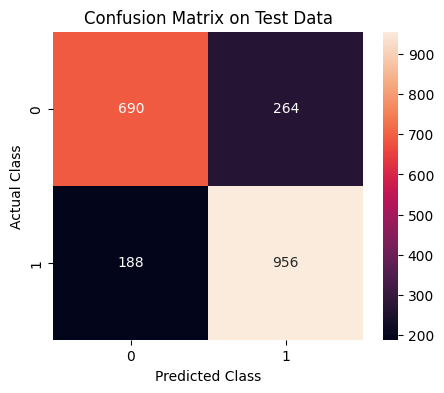

In [1402]:
plt.figure(figsize = (5,4))
sn.heatmap(confusion_matrix, annot = True, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix on Test Data')
plt.show()

In [1414]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       954
           1       0.78      0.84      0.81      1144

    accuracy                           0.78      2098
   macro avg       0.78      0.78      0.78      2098
weighted avg       0.78      0.78      0.78      2098



### Feature importance: ###
Catboost's feature imporance shows us which features' "splits" in the trees have made the biggest attribtion to the final value. We can see that 'group' is the feature, which contributed the most to deciding the final value.

In [1417]:
feature_importance = model.get_feature_importance(prettified = True)

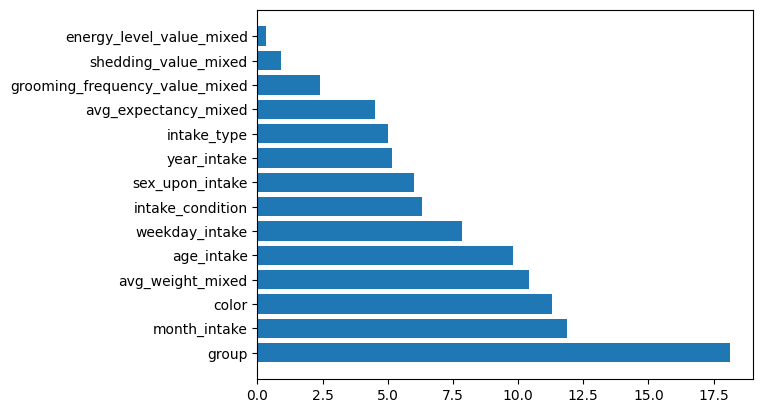

In [1418]:
keys = feature_importance.loc[:, 'Feature Id']
vals = feature_importance.loc[:, 'Importances']

plt.barh(keys, vals)
plt.show()

#### Shap values: ####
Shap values are another way to see feature contribution. They show the fair distribution of contribution across all features.

In [1421]:
test_pool = catboost.Pool(
    data = X_valid, 
    label = y_valid, 
    cat_features = cat_features
)

shap_values = model.get_feature_importance(
    data = test_pool, 
    type = 'ShapValues'
)
shap_values = shap_values[:,:-1]

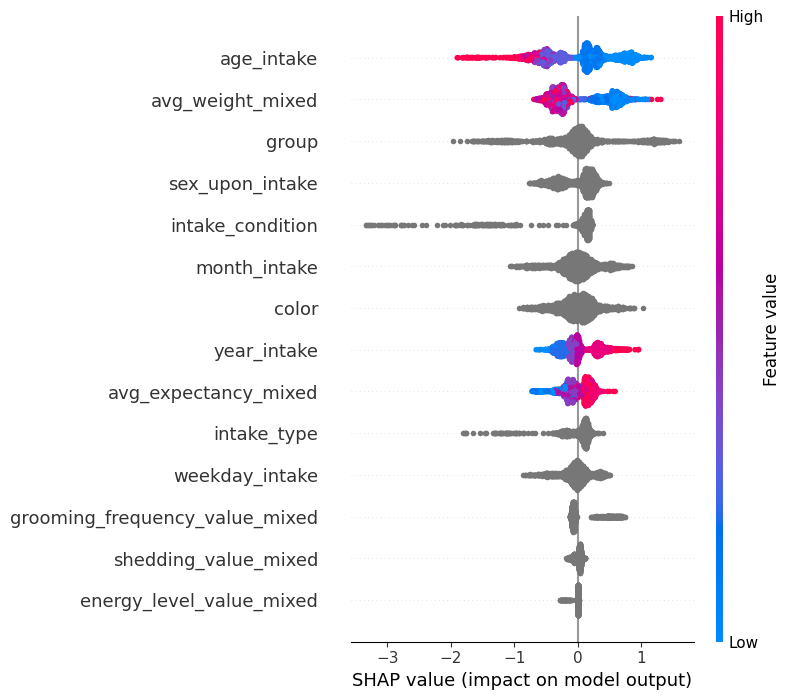

In [1422]:
shap.summary_plot(shap_values, X_valid)

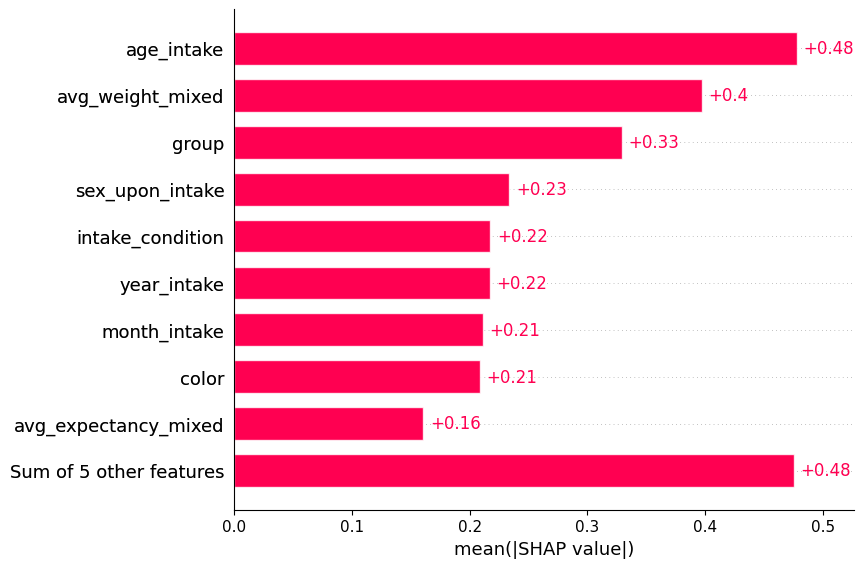

In [1423]:
explainer = shap.Explainer(model)

shap_values = explainer(X_test, y_test)
shap.plots.bar(shap_values)
plt.show()

## Conclusion and Room for Growth: ##

There is no recipe for the 'perfect' dog but maybe there is a reason to believe that some conditions exist, which make a dog more desirable. While this project has made a small step in the right direction, there is still room for improvement in terms of code cleanliness, more feature extraction from the text columns and looking into hyperparameters. Possible application of a model like this might be of help to shelter staff when they plan for budgets, room and overall resources. Being able to know if they have the capacity to take in more dogs, how many etc. <br/> 
With everything said and predicted, correctly or not, every dog deserves to have a home and be loved and the only thing humanity should throw away on the street is the need for shelter time prediction projects.

## References: ##

<ol>
    <li>
        <a href="https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes">Kaggle dataset - Austin Animal Center Shelter Intakes and Outcomes</a>
    </li>
    <li>
        <a href="https://www.kaggle.com/datasets/mexwell/dog-breeds-dataset">Kaggle dataset - Dog Breeds Dataset AKC</a>
    </li>
    <li>
        <a href="https://www.researchgate.net/publication/373805640_Predicting_Animal_Shelter_Pet_Adoption_Times_and_Feature_Importance_Analysis_using_CatBoost">Predicting Animal Shelter Pet Adoption Times and Feature Importance Analysis using CatBoost</a>
    </li>
    <li>
        <a href="https://catboost.ai/en/docs/concepts/tutorials">CatBoost Functionality Introduction</a>
    </li>
    <li>
        <a href="https://catboost.ai/en/docs/concepts/fstr#regular-feature-importance">CatBoost Feature Importances</a>
    </li>
</ol>
